In [1]:
import mdtraj as md
import os
import sys
import numpy as np
import scipy as sp
from scipy import optimize
from scipy.optimize import leastsq
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
import math
    
from numpy import log2, zeros, mean, var, sum, loadtxt, arange, \
                  array, cumsum, dot, transpose, diagonal, floor
from numpy.linalg import inv, lstsq


In [2]:
def block(x):
    # preliminaries
    d = log2(len(x))
    if (d - floor(d) != 0):
    #    print("Warning: Data size = %g, is not a power of 2." % floor(2**d))
    #    print("Truncating data to %g." % 2**floor(d) )
        x = x[:2**int(floor(d))]
    d = int(floor(d))
    n = 2**d
    s, gamma = zeros(d), zeros(d)
    mu = mean(x)
    # estimate the auto-covariance and variances 
    # for each blocking transformation
    for i in arange(0,d):
        n = len(x)
        # estimate autocovariance of x
        gamma[i] = (n)**(-1)*sum( (x[0:(n-1)]-mu)*(x[1:n]-mu) )
        # estimate variance of x
        s[i] = var(x)
        # perform blocking transformation
        x = 0.5*(x[0::2] + x[1::2])

    # generate the test observator M_k from the theorem
    M = (cumsum( ((gamma/s)**2*2**arange(1,d+1)[::-1])[::-1] )  )[::-1]

    # we need a list of magic numbers
    q =array([6.634897,  9.210340,  11.344867, 13.276704, 15.086272,
              16.811894, 18.475307, 20.090235, 21.665994, 23.209251,
              24.724970, 26.216967, 27.688250, 29.141238, 30.577914,
              31.999927, 33.408664, 34.805306, 36.190869, 37.566235,
              38.932173, 40.289360, 41.638398, 42.979820, 44.314105,
              45.641683, 46.962942, 48.278236, 49.587884, 50.892181])

    # use magic to determine when we should have stopped blocking
    for k in arange(0,d):
        if(M[k] < q[k]):
            break
    if (k >= d-1):
        print("Warning: Use more data")

    return (s[k]/2**(d-k))



In [3]:
def writhe(segment1,segment2):
    '''Compute writhe contribution from two input [x,y,z] cooridnate pairs'''
    s1 = segment1
    s2 = segment2
    #form unit vectors at the segment extremes:
    v13 = s2[0] - s1[0]
    v23 = s2[0] - s1[1]
    v24 = s2[1] - s1[1]
    v14 = s2[1] - s1[0]
    v = [v13,v23,v24,v14,v13,v23]
    e = []
    l13 = np.linalg.norm(v13)
    l23 = np.linalg.norm(v23)
    l24 = np.linalg.norm(v24)
    l14 = np.linalg.norm(v14)
    ls = [l13,l23,l24,l14]
    for l in ls:
        if l == 0.0:
            return 0
    e13 = v13/l13
    e23 = v23/l23
    e24 = v24/l24
    e14 = v14/l14
    e = [e13,e23,e24,e14,e13,e23]
    #compute the angles
    s = 0
    for i in range(1,len(e)-1):
        a = e[i-1]
        b =e[i]
        c = e[i+1]
        v1=a-b
        v3=c-b
        a=np.dot(v1,v3)/(np.linalg.norm(v1)*np.linalg.norm(v3))
        theta=np.arccos(np.clip(a, -1.0, 1.0))  
        s = s +theta
    w = np.sign(s)*2*np.pi - s
    return w


In [4]:
def writhe_matrix(segment1,segment2):
 v13 = s2[:,0] - s1[:,0]
 v23 = s2[:,0] - s1[:,1]
 v24 = s2[:,1] - s1[:,1]
 v14 = s2[:,1] - s1[:,0]
 v = [v13,v23,v24,v14,v13,v23]
 e = []
 l13 = np.linalg.norm(v13,axis=1)
 l23 = np.linalg.norm(v23,axis=1)
 l24 = np.linalg.norm(v24,axis=1)
 l14 = np.linalg.norm(v14,axis=1)
 ls = [l13,l23,l24,l14]   
 for l in ls:
        if np.sum(l) == 0.0:
            return 0
 e13 = v13/l13[:,None]
 e23 = v23/l23[:,None]
 e24 = v24/l24[:,None]
 e14 = v14/l14[:,None]
 e = [e13,e23,e24,e14,e13,e23] 
    #compute the angles
 s = 0
 for i in range(1,len(e)-1):
        a = np.asarray(e[i-1])
        b =np.asarray(e[i])
        c = np.asarray(e[i+1])
        #a =e[i-1]
        #b =e[i]
        #c = e[i+1]
        v1=a-b
        v3=c-b
        #a=np.dot(v1,v3)
        a=(v1*v3).sum(axis=1)/(np.linalg.norm(v1,axis=1)*np.linalg.norm(v3,axis=1))
        #a=np.dot(v1,v3)/(np.linalg.norm(v1,axis=1)*np.linalg.norm(v3,axis=1))
        theta=np.arccos(np.clip(a, -1.0, 1.0))  
        s = s +theta
 w = np.sign(s)*2*np.pi - s
 return w

In [5]:
#workdir='/Users/paulrobustelli/Asyn_LigandBinding'
#trajdir='/Users/paulrobustelli/Desktop/Trajectories/Asyn_DESRES/DESRES-Trajectory_biorxiv2021-asyn121to139_Lig41_5475823-no-water-glue/biorxiv2021-5475823-no-water-glue'
#pdb='/Users/paulrobustelli/Desktop/Trajectories/Asyn_DESRES/DESRES-Trajectory_biorxiv2021-asyn121to139_Lig41_5475823-no-water-glue/biorxiv2021-5475823-no-water-glue/asyn_ligand41_nowater.pdb'

In [7]:
#pdb='/Users/paulrobustelli/Desktop/Sa_calc/AR.R2R3.apo.pdb'
#trajectory='/Users/paulrobustelli/Desktop/Sa_calc/AR.R2R3.apo.rep0.xtc'


pdb='/Users/paulrobustelli/Desktop/Trajectories/AR_3.18.2021/R2_R3_APO/Trajectories/prot.drug.pdb'
trajectory='/Users/paulrobustelli/Desktop/Trajectories/AR_3.18.2021/R2_R3_APO/Trajectories/Replica_0.xtc'

trajectory='R2_R3_APO_rerun/'
parentdir='/Users/paulrobustelli/Desktop/Trajectories/AR_3.18.2021/'
workdir=parentdir+trajectory
trajdir=workdir+'Trajectories/'
pdb=trajdir+'R2R3.apo.pdb'
rep0=trajdir+'Replica_0.xtc'

print("workdir",workdir)
print("pdb",pdb)
print("trjaectory",rep0)

In [8]:
trj = md.load('/Users/paulrobustelli/Desktop/Sa_calc/AR.R2R3.apo.rep0.xtc', top='/Users/paulrobustelli/Desktop/Sa_calc/AR.R2R3.apo.pdb',stride=10)

#trajdir='/Users/paulrobustelli/Desktop/Trajectories/Asyn_DESRES/DESRES-Trajectory_biorxiv2021-asyn121to139_Lig41_5475823-no-water-glue/biorxiv2021-5475823-no-water-glue'
#trj = md.load(trajectory, top=pdb,stride=200)
trj.center_coordinates()
top = trj.topology
first_frame = 0
last_frame = trj.n_frames
n_frames=trj.n_frames

OSError: No such file: /Users/paulrobustelli/Desktop/Sa_calc/AR.R2R3.apo.pdb

In [8]:
nres=[]
for res in trj.topology.residues: nres.append(res.resSeq)
sequence=(' %s' % [residue for residue in trj.topology.residues])
resname=(' %s' % [residue.name for residue in trj.topology.residues])
resindex=(' %s' % [residue.index for residue in trj.topology.residues])
prot_top=top.subset(top.select('protein'))
prot_res=[]
for res in prot_top.residues: prot_res.append(res.resSeq)
prot_resname=(' %s' % [residue.name for residue in prot_top.residues])
residues=len(set(prot_res))

#log = open("/Users/paulrobustelli/Desktop/Sa_calc.log", "w")
print("** SYSTEM INFO **\n")
print("Number of atoms: %d\n" % trj.n_atoms)
print("Number of residues: %d\n" % len(set(nres)))
print("Number of protein residues: %d\n" % len(set(prot_res)))
print("Number of frames: %d\n" % trj.n_frames)
print("Starting frame: %d\n" % first_frame)
print("Last frame: %d\n" % last_frame)
print("sequence: %s\n" % sequence)
print("residue names: %s\n" % resname)
print("residue index: %s\n" % resindex)

residues=57
residue_offset=0
residue_number = range(residue_offset, residue_offset+residues)
print("Residue Number Range:",residue_number)


** SYSTEM INFO **

Number of atoms: 739

Number of residues: 58

Number of protein residues: 57

Number of frames: 2805

Starting frame: 0

Last frame: 2805

sequence:  [ACE0, LEU1, ASP2, TYR3, GLY4, SER5, ALA6, TRP7, ALA8, ALA9, ALA10, ALA11, ALA12, GLN13, CYS14, ARG15, TYR16, GLY17, ASP18, LEU19, ALA20, SER21, LEU22, HIS23, GLY24, ALA25, GLY26, ALA27, ALA28, GLY29, PRO30, GLY31, SER32, GLY33, SER34, PRO35, SER36, ALA37, ALA38, ALA39, SER40, SER41, SER42, TRP43, HIS44, THR45, LEU46, PHE47, THR48, ALA49, GLU50, GLU51, GLY52, GLN53, LEU54, TYR55, GLY56, NH257]

residue names:  ['ACE', 'LEU', 'ASP', 'TYR', 'GLY', 'SER', 'ALA', 'TRP', 'ALA', 'ALA', 'ALA', 'ALA', 'ALA', 'GLN', 'CYS', 'ARG', 'TYR', 'GLY', 'ASP', 'LEU', 'ALA', 'SER', 'LEU', 'HIS', 'GLY', 'ALA', 'GLY', 'ALA', 'ALA', 'GLY', 'PRO', 'GLY', 'SER', 'GLY', 'SER', 'PRO', 'SER', 'ALA', 'ALA', 'ALA', 'SER', 'SER', 'SER', 'TRP', 'HIS', 'THR', 'LEU', 'PHE', 'THR', 'ALA', 'GLU', 'GLU', 'GLY', 'GLN', 'LEU', 'TYR', 'GLY', 'NH2']

residue i

In [ ]:
dssp=md.compute_dssp(trj, simplified=True)
#np.savetxt(wdir+"/dssp.out",dssp,fmt='%s')
print(np.shape(dssp))
print(dssp)


In [ ]:
dssp=md.compute_dssp(trj, simplified=True)
#np.savetxt(wdir+"/dssp.out",dssp,fmt='%s')
print(np.shape(dssp))
print(dssp)
dsspH=np.copy(dssp)
dsspE=np.copy(dssp)
dsspH[dsspH=='H']=1                                                                                      
dsspH[dsspH=='E']=0                                                                                      
dsspH[dsspH=='C']=0                                                                                      
dsspH[dsspH=='NA']=0 
dsspH=dsspH.astype(int)
TotalH=np.sum(dsspH,axis=1) 
#np.savetxt(wdir+"/dssp.HTOT.dat",TotalH,fmt='%i')

#Hprop=np.sum(dsspH,axis=0).astype(float)/len(dsspH)
SE_H=np.zeros((len(prot_res),2))

for i in range(0,len(prot_res)): 
     data=dsspH[:,i].astype(float) 
     if(np.mean(data)>0):
      SE_H[i]=[np.mean(data),(block(data))**.5] 


dsspE[dsspE=='H']=0
dsspE[dsspE=='E']=1
dsspE[dsspE=='C']=0
dsspE[dsspE=='NA']=0
dsspE=dsspE.astype(int)
TotalE=np.sum(dsspE,axis=1) 

Eprop=np.sum(dsspE,axis=0).astype(float)/len(dsspE)
SE_E=np.zeros((len(prot_res),2))

for i in range(0,len(prot_res)):
     data=dsspE[:,i].astype(float)
     if(np.mean(data)>0):
      SE_E[i]=[np.mean(data),(block(data))**.5]
    
plt.errorbar(prot_res,SE_H[:,0],yerr=SE_H[:,1], capsize=5)
plt.errorbar(prot_res,SE_E[:,0],yerr=SE_E[:,1], capsize=5)


In [2]:
out="R2R2.writhe"

CAatoms=trj.topology.select('name CA')
CAdihe_index=[]
CAlabel=[]
CAang_index=[]
CAvec_index=[]
CApos=trj.xyz[:,CAatoms]

for i in range(0,len(CAatoms)):
     CAlabel.append(trj.topology.atom(CAatoms[i]).residue.resSeq)

print(np.array(CAlabel).astype(int))
wr=[]

#Calculate Total Chian Writhe#

for i in range(0,len(CApos)):
    w=0
    for j in range(0,len(CAlabel)-3):
     v1=CApos[i][j]; v2=CApos[i][j+1];
     for k in range(j+1,len(CAlabel)-1):
      v3=CApos[i][k]; v4=CApos[i][k+1];
      w+=writhe([v1,v2],[v3,v4])
    wr.append(w)


NameError: name 'trj' is not defined

In [347]:
#np.savetxt(out+'wr.dat',wr,'%.4lf')

#Calctulate writhe contribution for each Cai-Cai+1 segment
wtot=[]
writhe_matrix_by_res={}
for j in range(0,len(CAlabel)-1):
     w=[]
     for i in range(0,len(CApos)):
      v1=CApos[i][j]; v2=CApos[i][j+1];
      wf=[]
      for k in range(0,len(CAlabel)-1):
       v3=CApos[i][k]; v4=CApos[i][k+1];
       wf.append(writhe([v1,v2],[v3,v4]))
      w.append(wf)    
     writhe_matrix_by_res[CAlabel[j]]=np.asarray(w)     
     np.savetxt('%s.%s.writhe.dat'%(out,CAlabel[j]),w,'%.4lf')
     np.savetxt('%s.%s.sum.writhe.dat'%(out,CAlabel[j]),sum(w,axis=1),'%.4lf')
     wtot.append(np.mean(sum(w,axis=1)))
     print(CAlabel[j],np.mean(sum(w,axis=1)))
print(np.asarray(CAlabel).astype(int)[0:-1],np.asarray(wtot))
outsum=np.column_stack((np.asarray(CAlabel).astype(float)[0:-1],np.asarray(wtot)))
#np.savetxt('%s.sum.writhe.dat'%(out),outsum,'%d %.4lf')


[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56]
1 3.041412506747162
2 3.065831575065207
3 3.7956673961779215
4 3.9106289963575462
5 4.250316685768655
6 4.290566086820382
7 4.840818995895822
8 4.748946495514854
9 4.316220106734947
10 4.6308076925268535
11 4.5345471467943135
12 4.523501062600094
13 4.398463511384658
14 4.738451506118491
15 4.212895017940377
16 4.243730688968134
17 3.7486768100739236
18 4.064019945027523
19 4.295915129305615
20 4.292462801043696
21 4.169750508183787
22 4.321422871228604
23 4.294214751758341
24 4.179258116674666
25 4.31381351733077
26 4.039611977045184
27 4.369061981534173
28 4.063591440255277
29 4.14289004243175
30 4.110133556637043
31 4.193633000801444
32 3.9092840217030047
33 3.8691610448432017
34 4.537804720211717
35 4.046077186152393
36 4.259391350639563
37 4.111940129979321
38 4.349344630158338
39 4.169630195520418
40 4.32995553

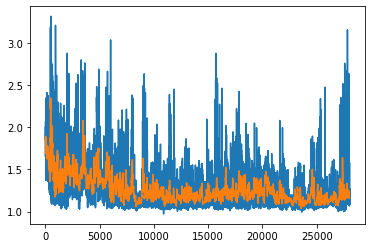

In [348]:
mass=[]
for at in trj.topology.atoms:
    mass.append(at.element.mass)
# calculate mass-weighted radius of gyration on all atoms
rg_all=md.compute_rg(trj, masses=np.array(mass))
plt.plot(rg_all)
plt.plot(np.convolve(rg_all,np.ones(N)/N,mode='valid'))

In [422]:
np.shape(wr)

(28044,)

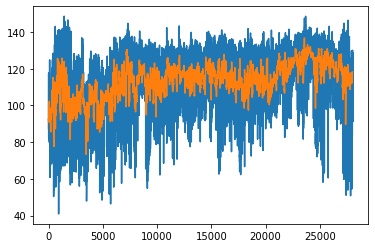

In [349]:
N=50
plt.plot(wr)
plt.plot(np.convolve(wr,np.ones(N)/N,mode='valid'))

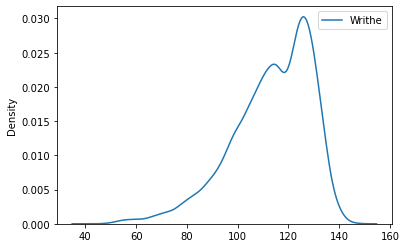

In [534]:
sns.kdeplot(wr,label='Writhe')
plt.legend(loc='upper right')


Text(0.5, 1.0, 'RMSD from start structure')

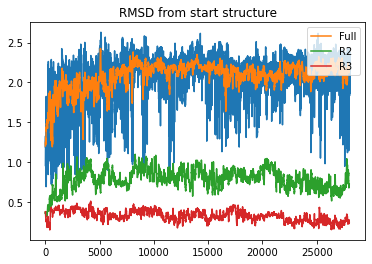

In [594]:
helix = md.load_pdb('/Users/paulrobustelli/Desktop/Sa_calc/R2R3_all_helix.pdb')
helix
top_helix = helix.topology

#top
backbone_helix=top_helix.select("backbone")
backbone=top.select("backbone")

sel1=top_helix.select("backbone and residue 1 to 25")
sel2=top_helix.select("backbone and residue 40 to 50")

rmsds = md.rmsd(trj,helix,atom_indices=backbone_helix)
rmsd1= md.rmsd(trj,helix,atom_indices=sel1)
rmsd2 = md.rmsd(trj,helix,atom_indices=sel2)

N=50
plt.plot(rmsds)
plt.plot(np.convolve(rmsds,np.ones(N)/N,mode='valid'),label='Full')
plt.plot(np.convolve(rmsd1,np.ones(N)/N,mode='valid'),label='R2')
plt.plot(np.convolve(rmsd2,np.ones(N)/N,mode='valid'),label='R3')
plt.legend(loc='upper right')
plt.title("RMSD from start structure")
#rmsds

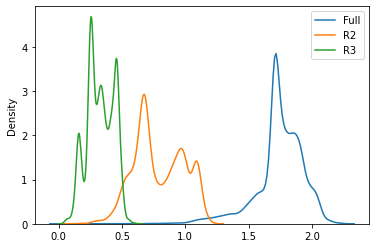

In [533]:
sns.kdeplot(rmsd,label='Full')
sns.kdeplot(rmsd1,label='R2')
sns.kdeplot(rmsd2,label='R3')
plt.legend(loc='upper right')



Total Writhe vs. Helix RMSD


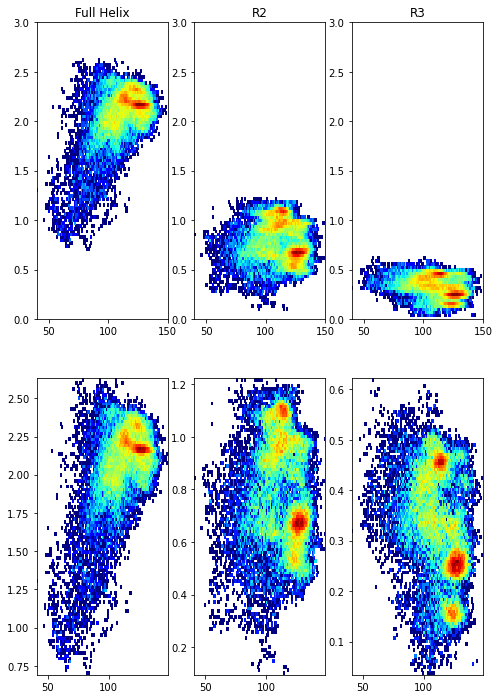

In [419]:
fig, ax = plt.subplots(2,3, figsize=((8,12)))
hist_i=ax[0,0].hist2d(wr,rmsds,bins=100,norm=colors.LogNorm(),range=[[40,150],[0,3.0]],cmap='jet')
hist_i=ax[0,1].hist2d(wr,rmsd1,bins=100,norm=colors.LogNorm(),range=[[40,150],[0,3.0]],cmap='jet')
hist_i=ax[0,2].hist2d(wr,rmsd2,bins=100,norm=colors.LogNorm(),range=[[40,150],[0,3.0]],cmap='jet')
hist_i=ax[1,0].hist2d(wr,rmsds,bins=100,norm=colors.LogNorm(),cmap='jet')
hist_i=ax[1,1].hist2d(wr,rmsd1,bins=100,norm=colors.LogNorm(),cmap='jet')
hist_i=ax[1,2].hist2d(wr,rmsd2,bins=100,norm=colors.LogNorm(),cmap='jet')
ax[0,0].set_title('Full Helix')
ax[0,1].set_title('R2')
ax[0,2].set_title('R3')

print("Total Writhe vs. Helix RMSD")

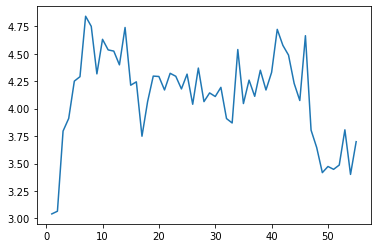

In [425]:
plt.plot(CAlabel[0:-1],wtot)
#plt.plot(Sa_ave*10)

Number of residues: 58



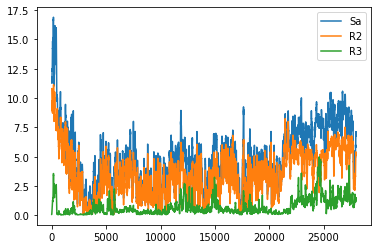

In [368]:
print("Number of residues: %d\n" % len(set(nres)))
RMS_start=1
RMS_stop=51
RMS=[]
for i in range(RMS_start,RMS_stop):
    #print(i,i+6)
    sel=top_helix.select("residue %s to %s and backbone" % (i,i+6))
    #print(sel)
    rmsd = md.rmsd(trj,helix,atom_indices=sel)
    RMS.append(rmsd)
RMS=np.asarray(RMS)
RMS

Sa_sum=np.zeros((trj.n_frames))
Sa=(1.0-(RMS/0.08)**8)/(1-(RMS/0.08)**12)
#Sa+=(1.0-(r/0.80)**8)/(1-(r/0.80)**12)
Sa_ave=np.average(Sa,axis=1)
Sa_total=np.sum(Sa,axis=0)
Sa_R2=np.sum(Sa[0:20],axis=0)
Sa_R3=np.sum(Sa[40:47],axis=0)

#plt.plot(Sa_total)
#plt.plot(Sa_R2)
plt.plot(np.convolve(Sa_total,np.ones(N)/N,mode='valid'),label='Sa')
plt.plot(np.convolve(Sa_R2,np.ones(N)/N,mode='valid'),label='R2')
plt.plot(np.convolve(Sa_R3,np.ones(N)/N,mode='valid'),label='R3')
plt.legend(loc='upper right')

#plt.plot(Sa_R3)


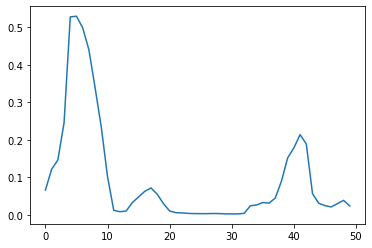

In [370]:
plt.plot(Sa_ave)

Total Writhe vs. Sa


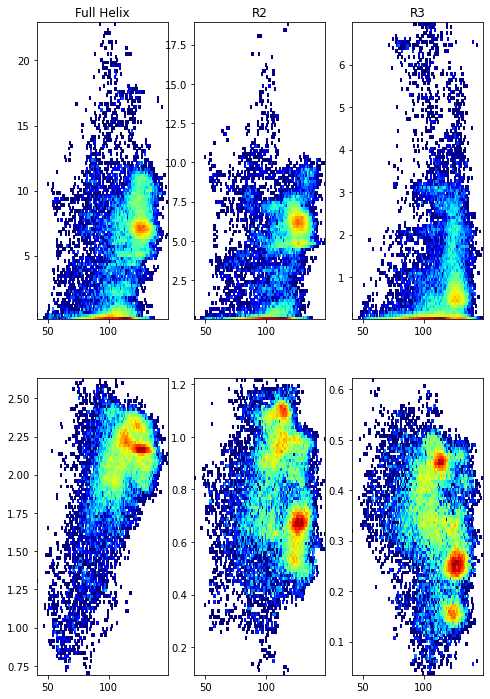

In [430]:
fig, ax = plt.subplots(2,3, figsize=((8,12)))
#hist_i=ax[0,0].hist2d(wr,Sa_total,bins=100,norm=colors.LogNorm(),range=[[40,150],[0,3.0]],cmap='jet')

hist_i=ax[0,0].hist2d(wr,Sa_total,bins=100,norm=colors.LogNorm(),cmap='jet')
hist_i=ax[0,1].hist2d(wr,Sa_R2,bins=100,norm=colors.LogNorm(),cmap='jet')
hist_i=ax[0,2].hist2d(wr,Sa_R3,bins=100,norm=colors.LogNorm(),cmap='jet')
hist_i=ax[1,0].hist2d(wr,rmsds,bins=100,norm=colors.LogNorm(),cmap='jet')
hist_i=ax[1,1].hist2d(wr,rmsd1,bins=100,norm=colors.LogNorm(),cmap='jet')
hist_i=ax[1,2].hist2d(wr,rmsd2,bins=100,norm=colors.LogNorm(),cmap='jet')
ax[0,0].set_title('Full Helix')
ax[0,1].set_title('R2')
ax[0,2].set_title('R3')

print("Total Writhe vs. Sa")

Rg vs. Sa/RMSD_helix


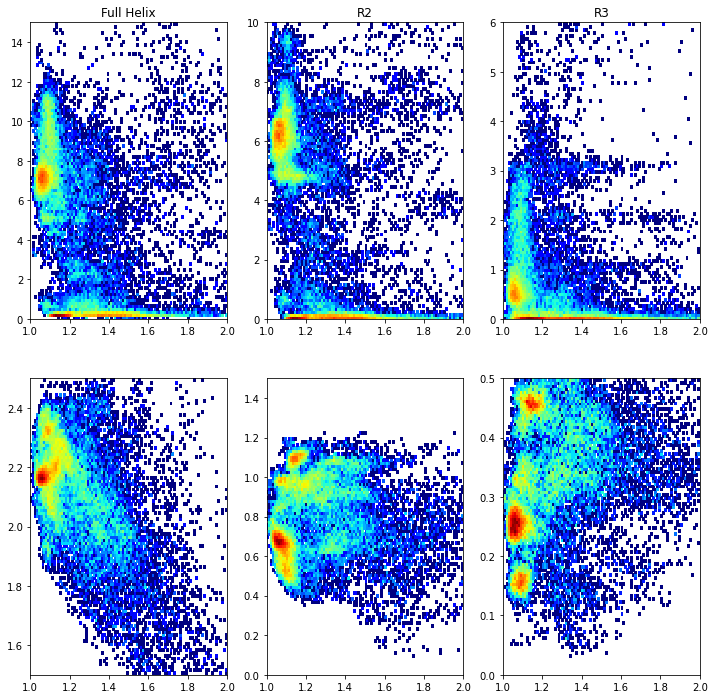

In [456]:
fig, ax = plt.subplots(2,3, figsize=((12,12)))
hist_i=ax[0,0].hist2d(rg_all,Sa_total,bins=100,norm=colors.LogNorm(),cmap='jet',range=[[1,2],[0,15]])
hist_i=ax[0,1].hist2d(rg_all,Sa_R2,bins=100,norm=colors.LogNorm(),cmap='jet',range=[[1,2],[0,10]])
hist_i=ax[0,2].hist2d(rg_all,Sa_R3,bins=100,norm=colors.LogNorm(),cmap='jet',range=[[1,2],[0,6]])
hist_i=ax[1,0].hist2d(rg_all,rmsds,bins=100,norm=colors.LogNorm(),cmap='jet',range=[[1,2],[1.5,2.5]])
hist_i=ax[1,1].hist2d(rg_all,rmsd1,bins=100,norm=colors.LogNorm(),cmap='jet',range=[[1,2],[0,1.5]])
hist_i=ax[1,2].hist2d(rg_all,rmsd2,bins=100,norm=colors.LogNorm(),cmap='jet',range=[[1,2],[0,0.5]])

ax[0,0].set_title('Full Helix')
ax[0,1].set_title('R2')
ax[0,2].set_title('R3')

print("Rg vs. Sa/RMSD_helix")

In [ ]:
hist=plt.hist2d(rg_all,wr,bins=100,norm=colors.LogNorm(),cmap='jet',range=[[1,2.0],[60,140]])
print("Rg vs. Total Writhe")

In [457]:
#Calctulate writhe contribution for each Cai-Cai+1 segment
#wtot=[]
writhe_matrix_by_res={}
for j in range(0,len(CAlabel)-1):
     w=[]   
     #print('v1:',j,j+1)
     writhe_matrix_by_res[CAlabel[j]]={}
     #Computing writh if CA_i-CA_i+1 with all other CA_segments for each frame
     for frame in range(0,len(CApos),20):
      v1=CApos[frame][j]; v2=CApos[frame][j+1];
      wf=[]
      #Calculate Writhe for j_j+1 to each segment k_k+1  
      for k in range(0,len(CAlabel)-1):
       #print('v2',k,k+1) 
       v3=CApos[i][k]; v4=CApos[i][k+1];
       #print("Frame:",frame,j,j+1,k,k+1)
       #Writhe between j_j+1 and k_k+1
       wf.append(writhe([v1,v2],[v3,v4]))
      #Add row of writhe to w 
      w.append(wf)
     writhe_matrix_by_res[CAlabel[j]]=np.asarray(w) 
     #np.savetxt('%s.%s.writhe.dat'%(out,CAlabel[j]),w,'%.4lf')
     #np.savetxt('%s.%s.sum.writhe.dat'%(out,CAlabel[j]),sum(w,axis=1),'%.4lf')
     #wtot.append(np.mean(sum(w,axis=1)))
     #print(CAlabel[j],np.mean(sum(w,axis=1)))
#print(np.asarray(CAlabel).astype(int)[0:-1],np.asarray(wtot))
#outsum=np.column_stack((np.asarray(CAlabel).astype(float)[0:-1],np.asarray(wtot)))

In [458]:
np.shape(writhe_matrix_by_res[1])

(1403, 55)

In [ ]:
fig, ax = plt.subplots(4, 4, figsize=((8,8)))
#hist1=ax[0,0].hist2d(Sa_R3, Sa_R2,bins=100,range=[[0,0.5],[0,0.6]],norm=colors.LogNorm(),cmap='jet'

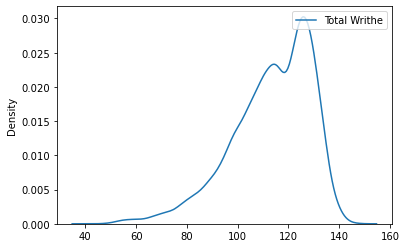

In [478]:
sns.kdeplot(wr,label='Total Writhe')
plt.legend(loc='upper right')


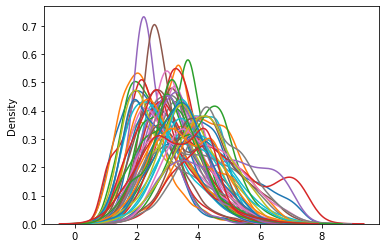

In [461]:
for i in range(1,55):
 sns.kdeplot(np.sum(writhe_matrix_by_res[i],axis=1),label=i)
#plt.legend(loc='upper right')
plt.show()

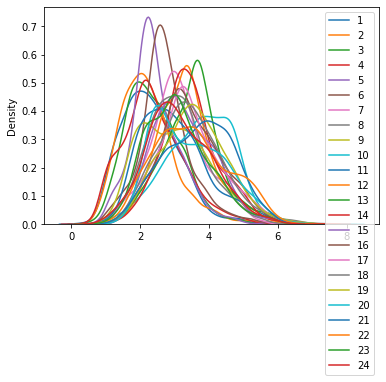

In [464]:
for i in range(1,25):
 sns.kdeplot(np.sum(writhe_matrix_by_res[i],axis=1),label=i)
plt.legend(loc='upper right')
plt.show()

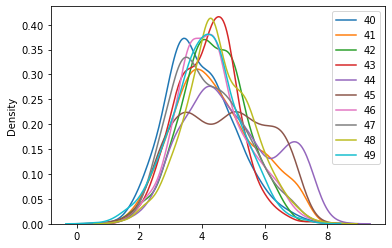

In [465]:
for i in range(40,50):
 sns.kdeplot(np.sum(writhe_matrix_by_res[i],axis=1),label=i)
plt.legend(loc='upper right')
plt.show()

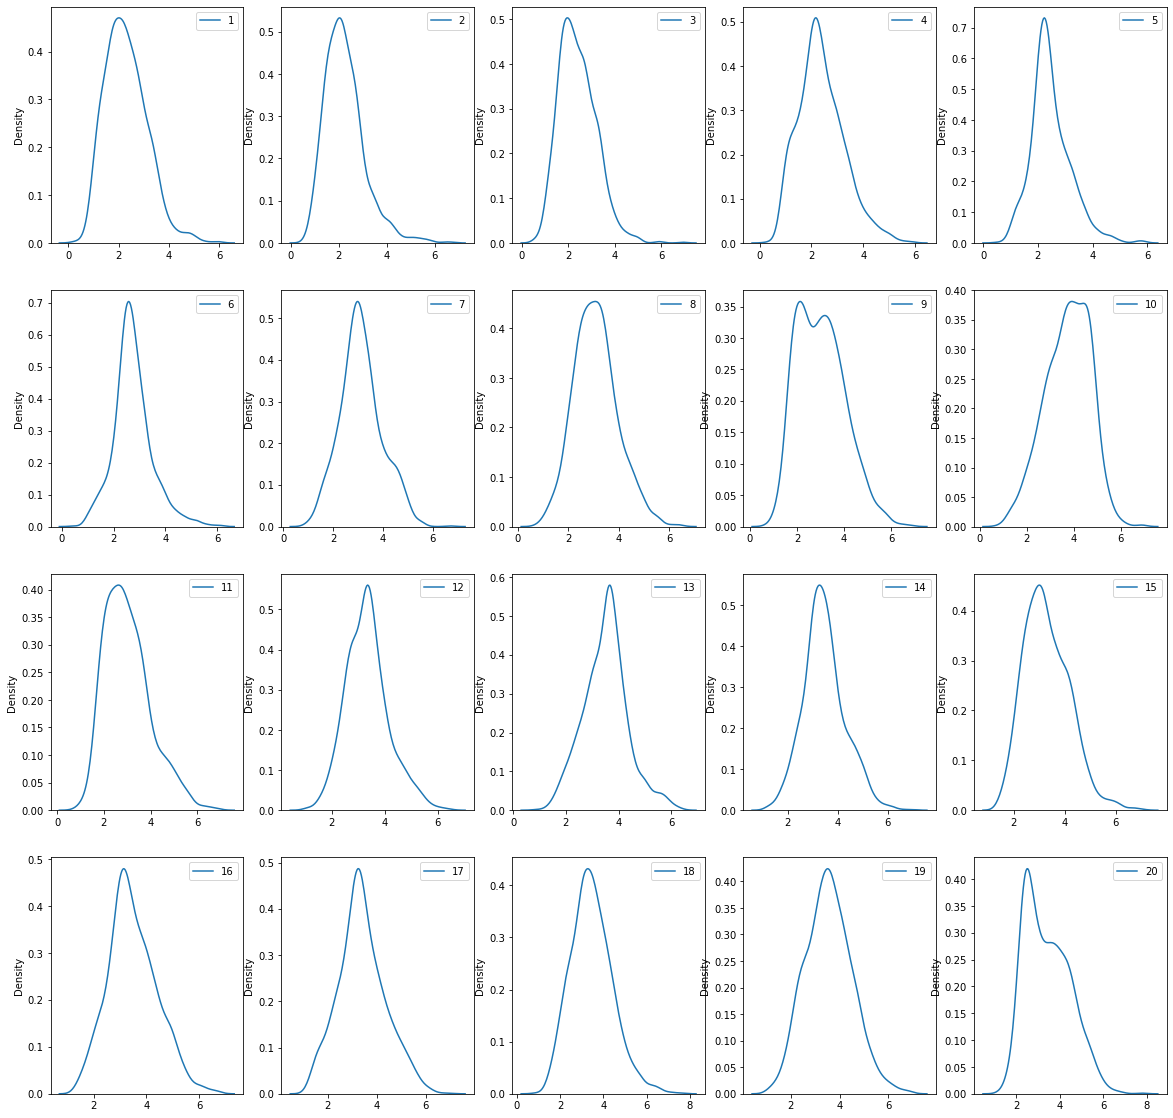

In [483]:
fig, ax = plt.subplots(4,5,figsize=((20,20)))
for i in range(0,4):
 for j in range(0,5):
  k=i*5+j+1
  #print(i,j,k)
  sns.kdeplot(np.sum(writhe_matrix_by_res[k],axis=1),label=k, ax=ax[i,j])  
  #hist=ax[i,j].hist(np.sum(writhe_matrix_by_res[k],axis=1),density='true',label=k,histtype='step')
  ax[i,j].legend(loc='upper right')

#hist=ax[3,4].hist(wr,label='Total',density='true',histtype='step')

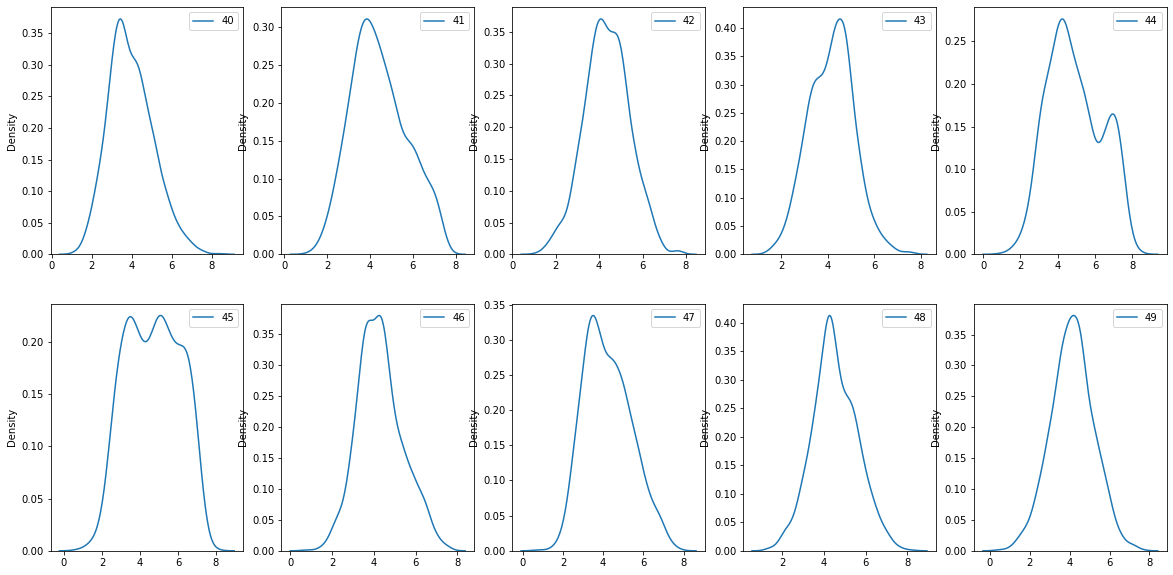

In [486]:
fig, ax = plt.subplots(2,5,figsize=((20,10)))
for i in range(0,2):
 for j in range(0,5):
  k=i*5+j+40
  #print(i,j,k)
  sns.kdeplot(np.sum(writhe_matrix_by_res[k],axis=1),label=k, ax=ax[i,j])  
  #hist=ax[i,j].hist(np.sum(writhe_matrix_by_res[k],axis=1),density='true',label=k,histtype='step')
  ax[i,j].legend(loc='upper right')


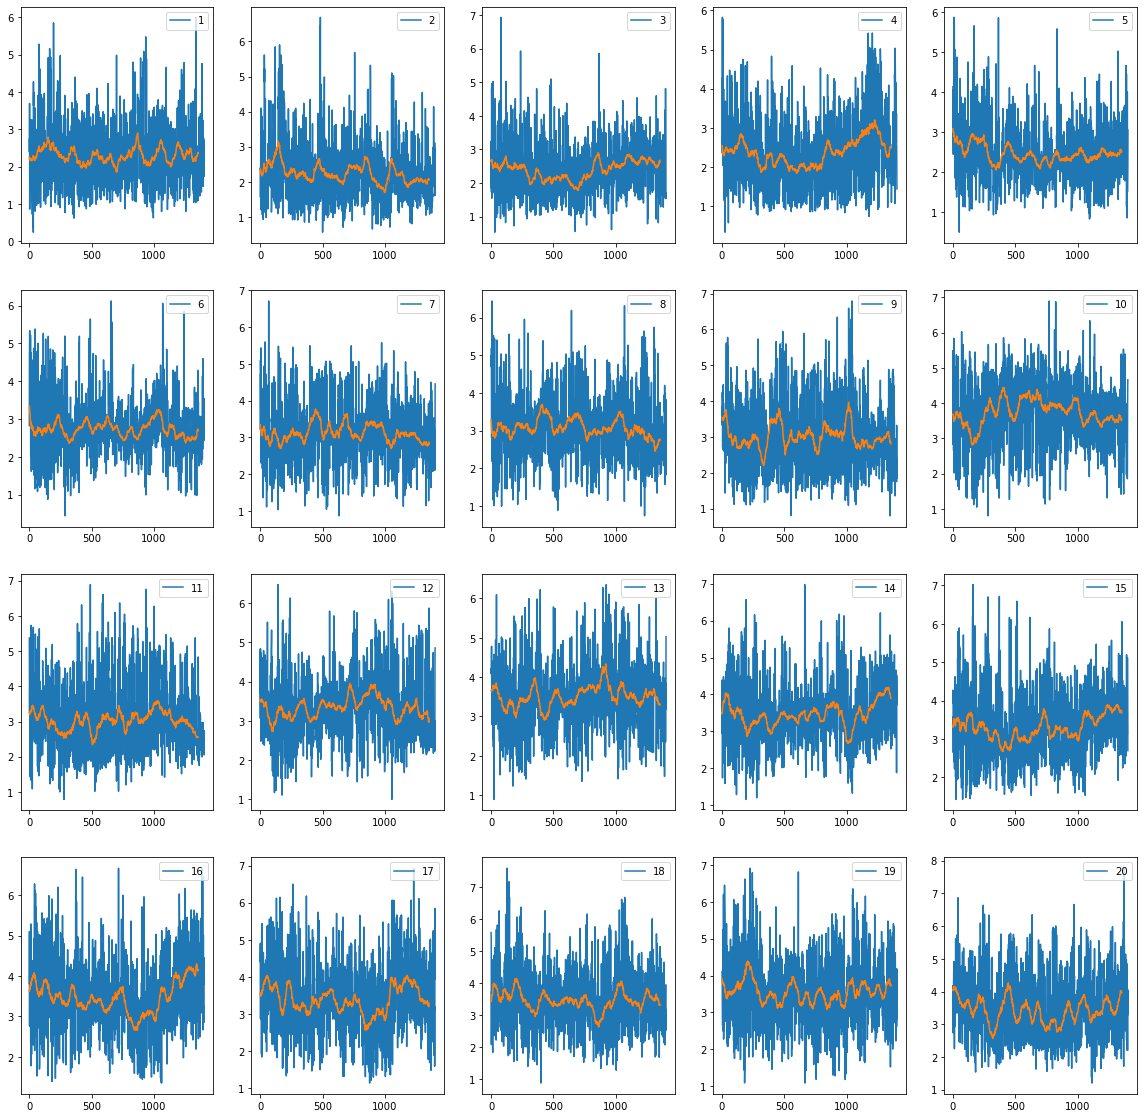

In [488]:
fig, ax = plt.subplots(4,5,figsize=((20,20)))

#Convulution Window
N=50

for i in range(0,4):
 for j in range(0,5):
   k=i*5+j+1
   hist=ax[i,j].plot(np.sum(writhe_matrix_by_res[k],axis=1),label=k)
   hist=ax[i,j].plot(np.convolve(np.sum(writhe_matrix_by_res[k],axis=1),np.ones(N)/N,mode='valid'))
   #hist=ax[i,j].sns.kdeplot(np.sum(writhe_matrix_by_res[k],axis=1),label=k)
   ax[i,j].legend(loc='upper right')


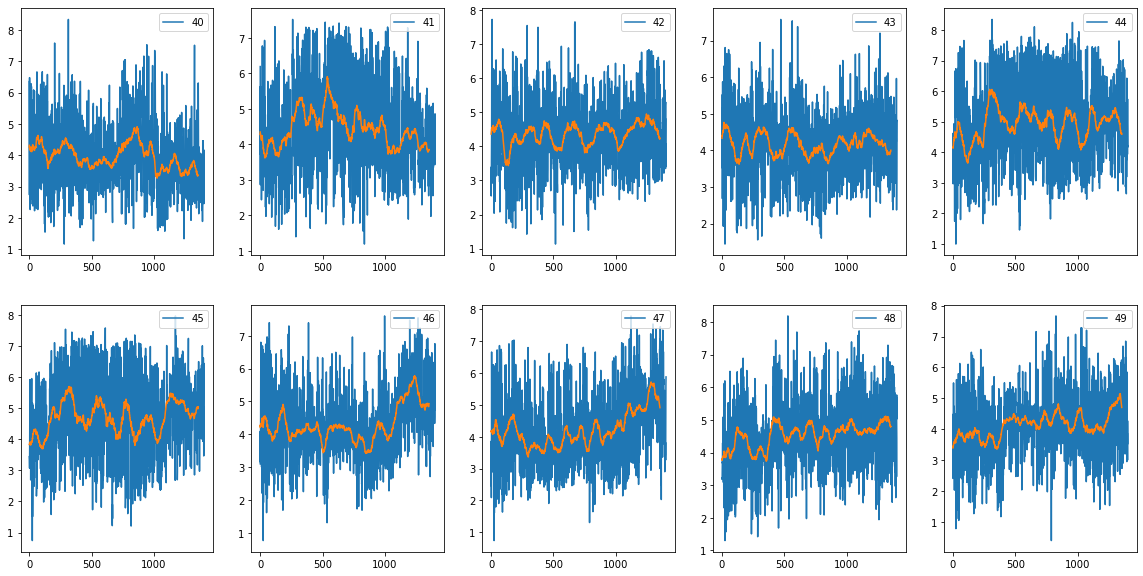

In [489]:
fig, ax = plt.subplots(2,5,figsize=((20,10)))

#Convulution Window
N=50

for i in range(0,2):
 for j in range(0,5):
   k=i*5+j+40
   hist=ax[i,j].plot(np.sum(writhe_matrix_by_res[k],axis=1),label=k)
   hist=ax[i,j].plot(np.convolve(np.sum(writhe_matrix_by_res[k],axis=1),np.ones(N)/N,mode='valid'))
   #hist=ax[i,j].sns.kdeplot(np.sum(writhe_matrix_by_res[k],axis=1),label=k)
   ax[i,j].legend(loc='upper right')

In [525]:
#Calculate a more Coarse Writhe contribution for each Cai-Cai+4 segment
#wtot=[]
writhe_matrix_by_res_coarse={}
for j in range(0,len(CAlabel)-4,4):
     w=[]   
     writhe_matrix_by_res_coarse[CAlabel[j]]={}
     #Computing writh if CA_i-CA_i+1 with all other CA_segments for each frame
     for frame in range(0,len(CApos),20):
      #print('v1:',j,j+4)
      v1=CApos[frame][j]; v2=CApos[frame][j+4];
      wf=[]
      #Calculate Writhe for j_j+4 to each segment k_k+4  
      for k in range(0,len(CAlabel)-4,4):
       v3=CApos[i][k]; v4=CApos[i][k+4];
       #Writhe between j_j+4 and k_k+4
       #print('v1:',j,j+4,'v2',k,k+4)
       wf.append(writhe([v1,v2],[v3,v4]))
      #Add row of writhe to w 
      w.append(wf)
     writhe_matrix_by_res_coarse[CAlabel[j]]=np.asarray(w) 

In [539]:
wr_coarse=[]

#Calculate Total Chian Writhe#

for i in range(0,len(CApos),20):
    w=0
    for j in range(0,len(CAlabel)-4,4):
     v1=CApos[i][j]; v2=CApos[i][j+4];
     for k in range(j+4,len(CAlabel)-4,4):
      v3=CApos[i][k]; v4=CApos[i][k+4];
      w+=writhe([v1,v2],[v3,v4])
    wr_coarse.append(w)


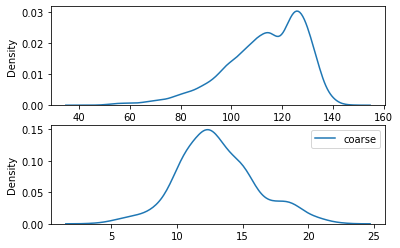

In [571]:
fig, ax = plt.subplots(2)
sns.kdeplot(wr,label='writhe', ax=ax[0])  
sns.kdeplot(wr_coarse,label='coarse', ax=ax[1])  

plt.legend(loc='upper right')


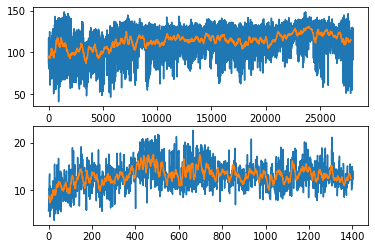

In [567]:
fig, ax = plt.subplots(2)
ax[0].plot(wr)
N=200
ax[0].plot(np.convolve(wr,np.ones(N)/N,mode='valid'))

ax[1].plot(wr_coarse)
N=10
ax[1].plot(np.convolve(wr_coarse,np.ones(N)/N,mode='valid'))

(28044,) (1403,) (1403,)
[[1.0000 0.3217]
 [0.3217 1.0000]]


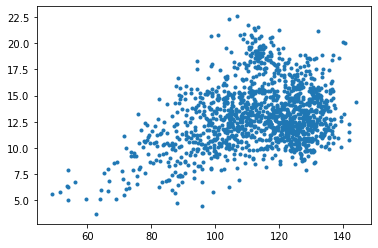

In [591]:
print(np.shape(wr),np.shape(wr[0::20]),np.shape(wr_coarse))
wr_s20=wr[0::20]
#plt.plot(wr_s20)
print(np.corrcoef(wr[0::20],wr_coarse))
plt.scatter(wr_s20,wr_coarse,marker='.')

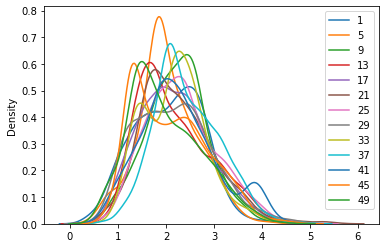

In [536]:
for i in writhe_matrix_by_res_coarse:
 #print(i)   
 sns.kdeplot(np.sum(writhe_matrix_by_res_coarse[i],axis=1),label=i)
plt.legend(loc='upper right')
plt.show()


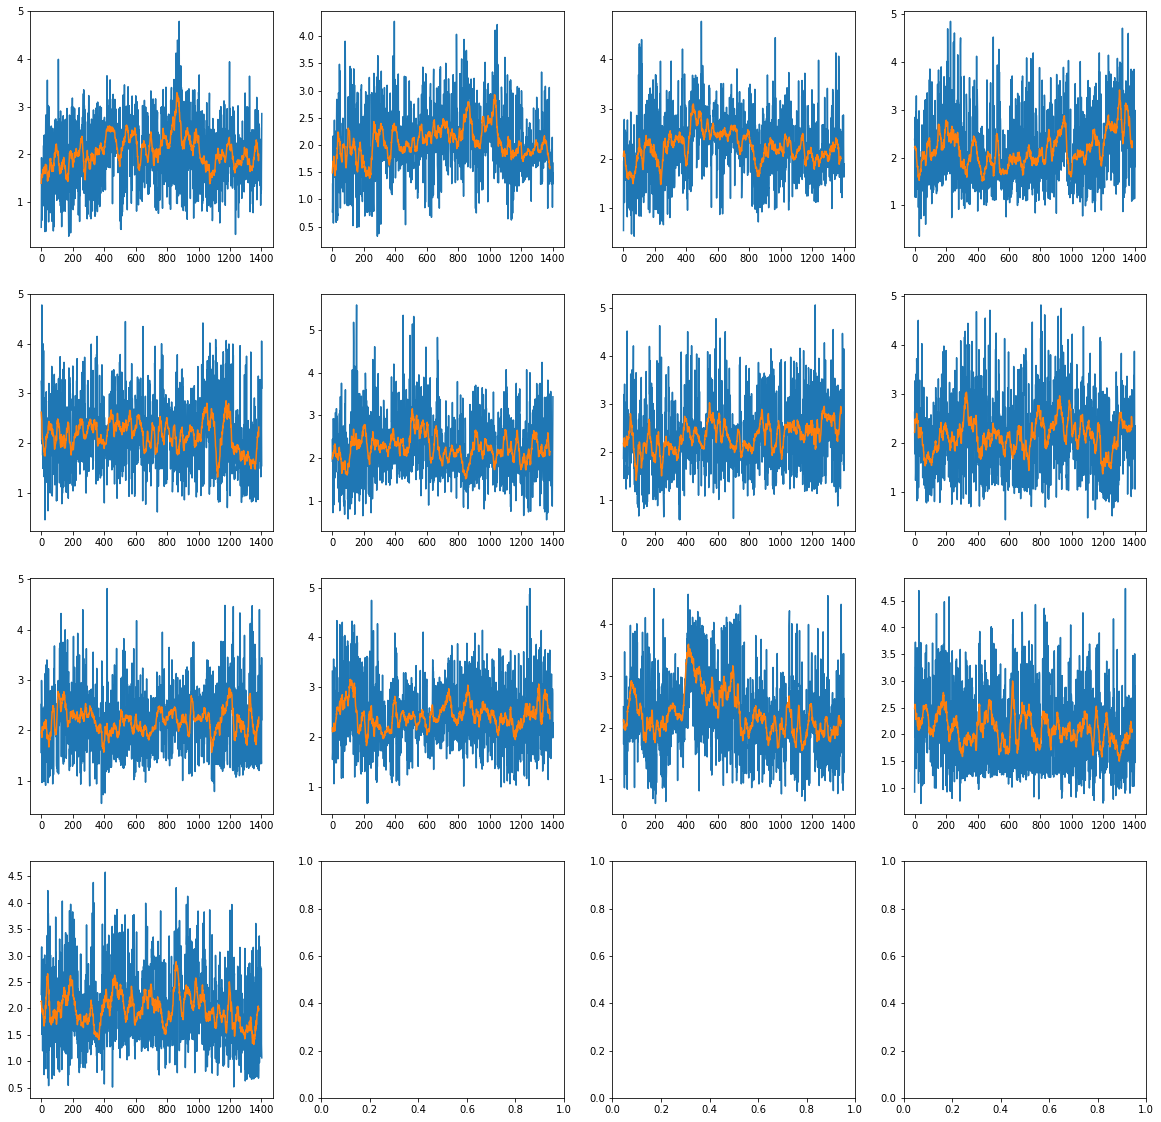

In [537]:
fig, ax = plt.subplots(4,4,figsize=((20,20)))

#Convulution Window
N=20

k=1
for i in range(0,4):   
 for j in range(0,4):
   #print(i,j,k) 
   if(k<53):
    hist=ax[i,j].plot(np.sum(writhe_matrix_by_res_coarse[k],axis=1),label=k)
    hist=ax[i,j].plot(np.convolve(np.sum(writhe_matrix_by_res_coarse[k],axis=1),np.ones(N)/N,mode='valid'))
    k+=4

   #hist=ax[i,j].sns.kdeplot(np.sum(writhe_matrix_by_res[k],axis=1),label=k)
   #ax[i,j].legend(loc='upper right')
